In [213]:
from typing import List
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

class NeuralNetwork:
    """
    creates a fully connected network given the number of neurons in each layer.
    """

    def __init__(self, n_input: int, layer_neurons_count: List[int], lr) -> None:
        self.__lr = lr
        self.__weights = []
        self.__biases = []
        self.__n_layers = len(layer_neurons_count)
        layer_neurons_count = [n_input] + layer_neurons_count
        for i in range(1, len(layer_neurons_count)):
            self.__weights.append(np.ones((layer_neurons_count[i - 1], layer_neurons_count[i])))
            self.__biases.append(np.ones((layer_neurons_count[i], 1)))

        self.__sigfunc = np.vectorize(self.__sigmoid)
        self.__dsigfunc = np.vectorize(self.__dsigmoid)
        assert len(self.__weights) == len(self.__biases) == self.__n_layers, "n_layers should match weights and biases"
        self.__costs = []

    def __cost(self, y_pred, y_actual):
        return (y_pred - y_actual) ** 2

    def __dcost(self, y_pred, y_actual):
        return 2 * (y_pred - y_actual)

    def __sigmoid(self, x):
        return 1 / (1 + np.e**(-x))

    def __dsigmoid(self, x):
        return self.__sigmoid(x) * (1 - self.__sigmoid(x))

    def __forward_pass(self, x, y):
        assert x.shape[0] == self.__weights[0].shape[0], "input shape does not match weights shape"
        
        self.__zs = []
        self.__outputs = [x]
        o = x
        for i in range(self.__n_layers):
            w = self.__weights[i]
            b = self.__biases[i]
            z = w.T @ o + b
            self.__zs.append(z)
            o = self.__sigfunc(z)
            self.__outputs.append(o)

        assert len(self.__outputs) == self.__n_layers + 1, "outputs should be 1 more than n_layers"

    def __backward_pass(self, x, y):
        y_pred = self.__outputs[-1]
        self.__costs.append(self.__cost(y_pred=y_pred, y_actual=y))

        z = self.__zs[-1]
        delta = np.multiply(self.__dcost(y_pred=y_pred, y_actual=y), self.__dsigmoid(z)) 
        for i in range(self.__n_layers-1, -1, -1):
            delta_b = delta
            self.__biases[i] -= self.__lr * delta_b

            o_1 = self.__outputs[i]
            delta_w = o_1 @ delta.T
            self.__weights[i] -= self.__lr * delta_w

            if i == 0:
                break # finished, can not calculate delta_0

            delta = np.multiply(self.__weights[i] @ delta, self.__dsigfunc(self.__zs[i-1])) 
        

    def fit(self, input_pairs, n_epochs):
        for i in tqdm(range(n_epochs), desc=f"Training:"):
            for (x, y) in input_pairs:
                self.__forward_pass(x, y)
                self.__backward_pass(x, y)

    def plot_costs(self):
        x = range(len(self.__costs))
        y = [c[0] for c in self.__costs]
        plt.plot(x, y, label="Cost")
        plt.xlabel("# Epoch")
        plt.ylabel("Cost")
        plt.legend()
        plt.show()

    def print_params(self):
        print("weights:")
        for w in self.__weights:
            print(w)
        print()
        print("biases:")
        for b in self.__biases:
            print(b)
        

Training:: 100%|██████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1208.15it/s]


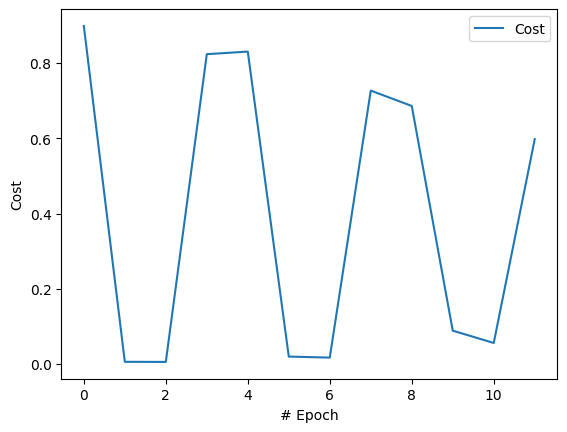

weights:
[[0.99746578 0.99746578]
 [0.99585463 0.99585463]]
[[0.34100366]
 [0.34100366]]

biases:
[[0.93811186]
 [0.93811186]]
[[0.1790979]]


In [214]:
nn = NeuralNetwork(n_input=2,layer_neurons_count=[2,1], lr=1)

pairs = [
    (np.array([[1], [1]]), 0),
    (np.array([[1], [0]]), 1),
    (np.array([[0], [1]]), 1),
    (np.array([[0], [0]]), 0),
]

nn.fit(input_pairs=pairs, n_epochs=3)
nn.plot_costs()
nn.print_params()